

# 1. Introduction <a class="anchor" id="first-bullet"></a>

Turbofan engines are gas turbine engines often use in aircraft propulsion. In this document, we analyze data relative to such engines. The **aim** is to model and predict the Remaining Useful Life (RUL) as accurately as possible. In a real-life setup, such a model can be used for:

- **Root-cause analysis**, analyzing historical data and identifying patterns or behaviors that lead to failures
- **Real-time monitoring**, generating alerts before the actual failure occurs



## 1.1 Problem definition

The diagram below summarizes the structure of a turbofan engine: 

<img src="engine.png" alt="Diagram of engine" width="500" align="center"/>

The data set consists of multiple multivariate time series. Each time series is from a different engine, i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation are considered normal, i.e., it is not considered a fault condition. Three operational settings have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.
    
The engine is operating normally at the start of each time series, and develops a fault at some point during the series: the fault grows in magnitude until system failure.


## 1.2 Modeling Process and Approach

The general modeling outline is described in the diagram below and is as follows:

1. Load data. In this case, data is stored in text files. Generally speaking, data can be fetched from any source like xlsx files or a database
2. Pre-process data, also called data cleaning. This step is crucial to understand and trust the data. One would often iterate between:
    - Transformation: filtering, standardization, filling missing values, engineering new features
    - Visualization: graphical summary of the data helps to identify possible issues
3. Model training and selection. Here we search over different modeling approaches and select the optimal one based on relevant metrics. Techniques as cross validation and grid search for hyperparameter optimization are very useful.
4. Using the best modeling approach we do:
    - Root-cause analysis based on historical data
    - Predictions using new online data
    
<img src="data_flow.png" alt="Workflow data modeling" width="1000" align="center"/>


In this notebook we model the engine failures from two different points of view, trying to answer the following questions:

> _How many cycles are left until the engine fails?_

In this case we deal with regression models

> Will the engine fail in less than 10 cycles? What is the probability?

This case falls into the category of classification modeling


## 1.3 _Library import and enviroment setup_

We use existing data science libraries that provide reliability and speed, combined with a custom-made library that focuses on the specific problematic of predictive maintenance.

In [13]:
import sys
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# General
from pathlib import Path
import warnings

# Data & modeling
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 500)
import lightgbm as lgb
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    f1_score,
    confusion_matrix,
)
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
import shap
from pdpbox import pdp, get_dataset, info_plots

# Plotting
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

# Custom package
from storpdm import DATA_PATH
from storpdm.make_dataset import download_dataset, import_dataset
from storpdm.visualize import (
    visualise_sensor_correlation_all_engine,
    visualise_sensor_data_distribution,
    plot_time_history_all_engines,
    visualise_sensor_correlation_double,
    interactive_rul_series,
    actual_vs_pred,
    display_roc_pr,
    display_tp_fp,
    plot_confusion_matrix,
    plot_prob_RUL,
)
from storpdm.build_features import (
    find_correlated_data,
    list_correlated_data,
    find_time_independent_columns,
    add_calculated_rul,
    prepare_training_data,
)
from storpdm.utils import metrics_threshold
from storpdm.train_model import EstimatorSelectionHelper

# 2. Data Exploration and Cleaning


## 2.1 Data Loading and Processing

Let's download the data to a local folder and unzip it


In [15]:
## Run the download function only once
if len(list(Path("data/raw").glob("train_*.txt"))) == 4:
    print("Raw data has been downloaded")
else:
    download_dataset()

Raw data has been downloaded


In [16]:
# Load datasets and display
df_rul, df_train, df_test = import_dataset(filename="FD001")
display(df_train)

,id,cycle,op1,op2,op3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,EnginePresRatio,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## 2.2 Data cleaning and visualization

Now that the data is loaded, we do the following pre-processing:

- Remove correlated sensors. Some sensors have a correlation of "almost" 1 or -1. This means they might have different scales but their behavior is the same. Hence, we remove all the correlated sensors but one.
- Constant data with time. Some sensor like _FanInletTemp_ are constant, i.e. the sensor signal moght have gotten stuck. This sensor holds no relevant information, hence it shoudl be removed from the dataset.

After the data cleanig we visualize the distribution of the remaining features just to make sure nothings stands outs (outliers and unexpected behaviors)

In [17]:
# Reduce / Eliminate highly-correlated sensors.
correlation_threshold = 0.99
correlated_data = find_correlated_data(df_train, correlation_threshold)
columns_to_be_removed = list_correlated_data(correlated_data)

In [18]:
print(f"Removing {columns_to_be_removed} from columns")
df_train_proc = df_train.drop(columns_to_be_removed, axis=1)

Removing ['FanInletPres', 'EnginePresRatio', 'BurnerFuelAirRatio'] from columns


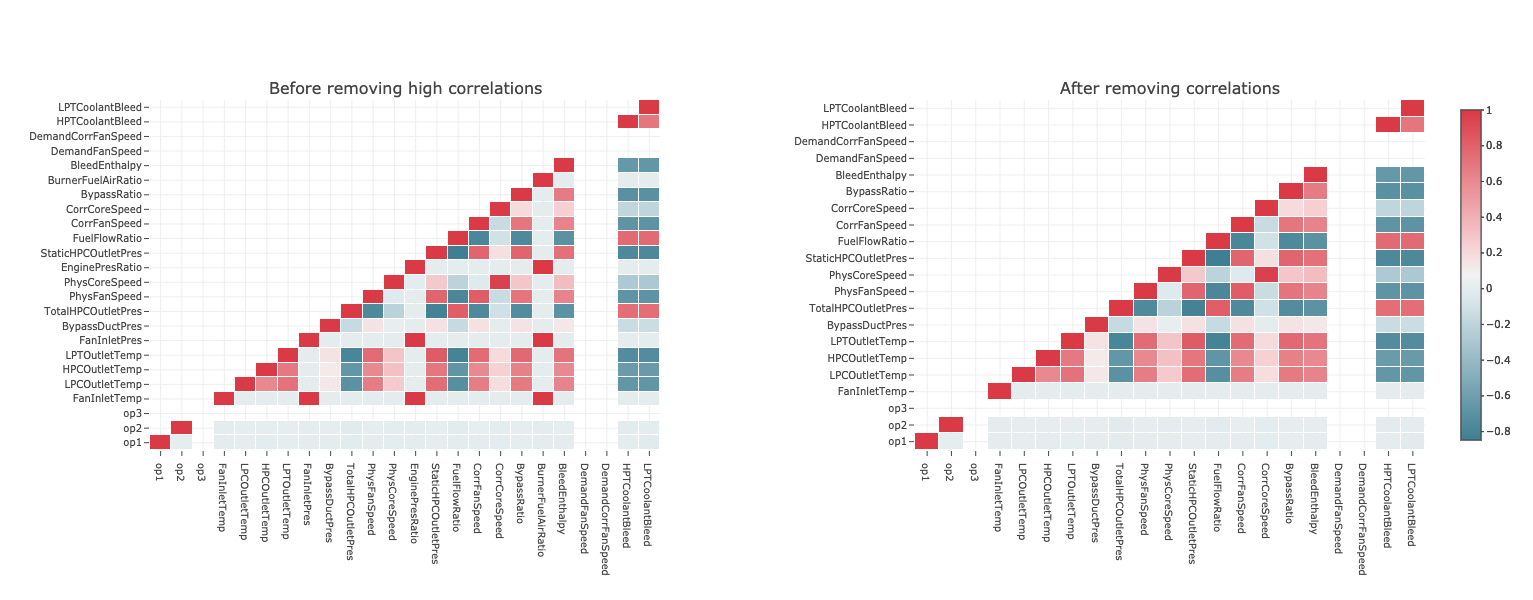

In [19]:
subplot_titles = ("Before removing high correlations", "After removing correlations")
fig = visualise_sensor_correlation_double(df_train, df_train_proc, subplot_titles)
fig.show()

On the left plot, we observe that some features are hihgly correlated. On the right plot we confirm they have been remove

Next, let's plot the distribution of the sensor data.

<Figure size 1080x1080 with 0 Axes>

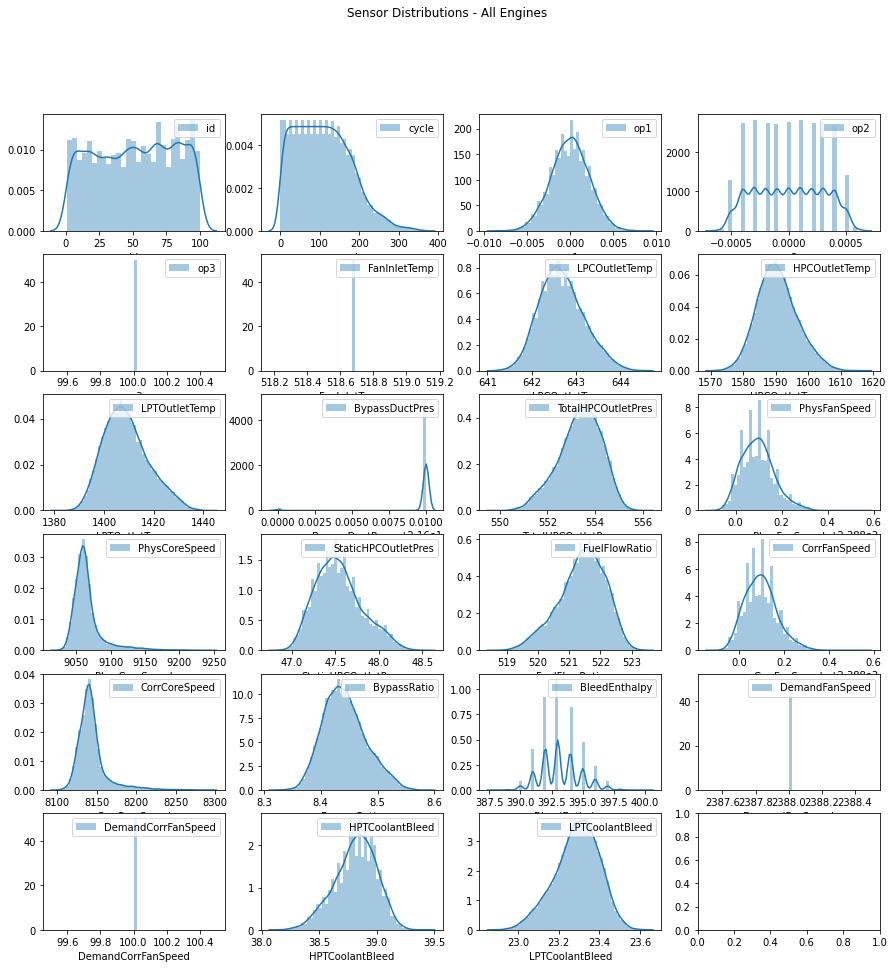

In [20]:
plt.figure(figsize=(15, 15))
with warnings.catch_warnings(record=True):
    fig = visualise_sensor_data_distribution(df_train_proc)

It seems like some values are constant. We could have guessed this by looking at the raw table. We clean those constant columns too.

In [21]:
# Find columns that does not change with time.
time_independent_columns = find_time_independent_columns(df_train_proc)

print(f"Removing constant columns: {time_independent_columns}")
df_train_proc2 = df_train_proc.drop(time_independent_columns, axis=1)

# Add Remaining Useful Life (RUL) to dataset.
df_train_proc2 = add_calculated_rul(df_train_proc2)

display(df_train_proc2)

Removing constant columns: ['op3', 'FanInletTemp', 'BypassDuctPres', 'PhysFanSpeed', 'CorrFanSpeed', 'DemandFanSpeed', 'DemandCorrFanSpeed']


,id,cycle,op1,op2,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,9046.19,47.47,521.66,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,9044.07,47.49,522.28,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,9052.94,47.27,522.42,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,9049.48,47.13,522.86,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,9055.15,47.28,522.19,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,9065.52,48.07,519.49,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,9065.11,48.04,519.68,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,9065.90,48.09,520.01,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,9073.72,48.39,519.67,8139.29,8.5389,395,38.29,23.0640,1


The table above is clean and reasy to be used. Let's visualize some of the time series separately. Onthe X axis, we show the Remaining Useful Life (RUL). As we approach RUL=0 it means the engine is about to fail.

On the graph below, select the variable to plot in the dropdown menu. Variable `PhysCoreSpeed` seems quite relevant, as its values diverge as the RUL decreases.

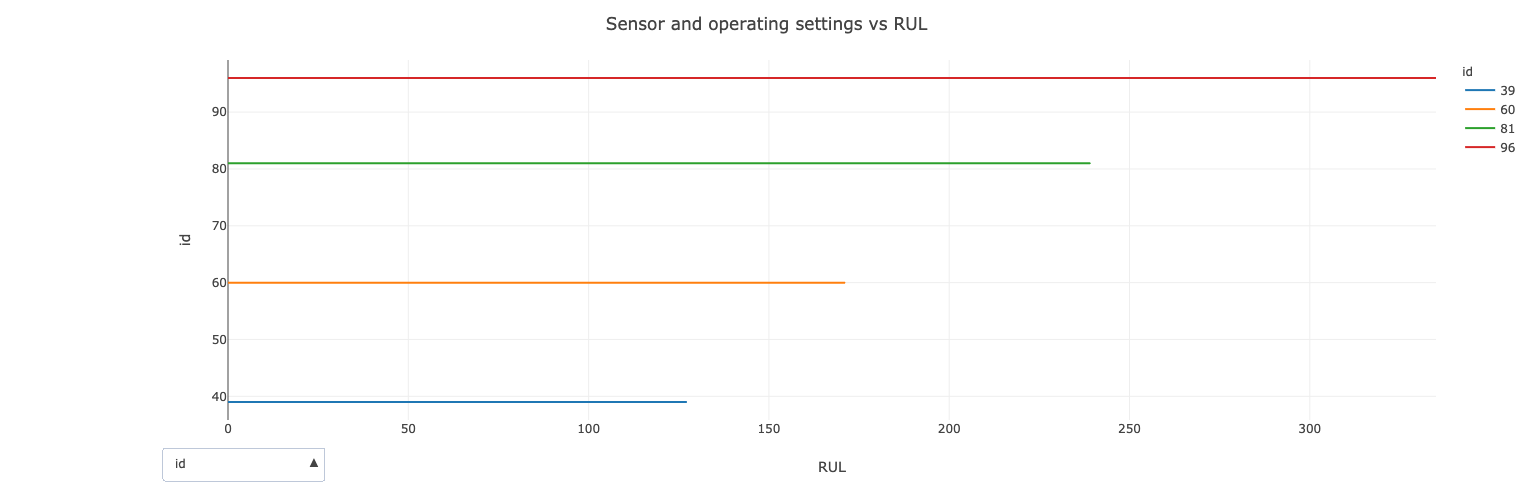

In [22]:
fig = interactive_rul_series(df_train_proc2, id_filter=[96,39,60,81])
fig.show()

## 3. Remaining Useful Life (RUL) Modeling

In this section we focus on developing a model that answers the question to _how many cycles are left until the engine fails_. From the machine learning point of view, this means we train a regression model.


### 3.1 Regression Model: Training and Selection

We perform a comparison of 3 different models with several combinations of hyperparameters and automatically select the best one:

1. Linear model with lasso penalization
2. Gradient boosted regression trees
3. Neural network: Multi-Layer Perceptron (MLP) regressor. 

When selecting a model, we respect the principles of cross-validation to avoid overfitting.

In [23]:
# Define models
models = {
    "linear": Ridge(normalize=True),
    "lgb": lgb.LGBMRegressor(),
    "mlp": Pipeline(
        [("std", MinMaxScaler()), ("m1", MLPRegressor(early_stopping=True))]
    ),
}

# Define hyperparam search space
params = {
    "linear": {},
    "lgb": {
        "n_estimators": [100, 500],
        "learning_rate": [0.005, 0.01],
        "max_depth": [5, 10, 15, 20],
    },
    "mlp": {
        "m1__hidden_layer_sizes": [(128), (64, 32)],
        "m1__learning_rate_init": [0.001, 0.005, 0.01],
    },
}

In [24]:
# Split train and test
X_train, X_test, y_train, y_test = prepare_training_data(
    df=df_train_proc2, target_col="RUL", discard_cols="id"
)

In [25]:
%%time
estim_grid = EstimatorSelectionHelper(models, params)
estim_grid.fit(
    X_train, y_train, scoring="neg_root_mean_squared_error", n_jobs=2, cv=None
)

Running GridSearchCV for linear.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for lgb.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.7s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  1.1min finished


Running GridSearchCV for mlp.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  2.4min finished


CPU times: user 25.1 s, sys: 3.11 s, total: 28.2 s
Wall time: 3min 38s


Below we show the top 5 models.

In [26]:
model = estim_grid.best_model
print(f"Winner model: {model}")

print(f"Total number of models: {estim_grid.score_summary().shape[0]}")
estim_grid.score_summary().head()

Winner model: LGBMRegressor(learning_rate=0.01, max_depth=20, n_estimators=500)
Total number of models: 23


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,model,param_learning_rate,param_max_depth,param_n_estimators,param_m1__hidden_layer_sizes,param_m1__learning_rate_init
15,1.384146,0.205177,0.045148,0.002225,"{'learning_rate': 0.01, 'max_depth': 20, 'n_es...",-36.085727,-36.026132,-35.596279,-37.287655,-35.836283,-36.166415,0.586073,1,-32.142465,-32.193598,-32.205210,-31.863161,-32.120410,-32.104969,0.124915,lgb,0.01,20,500,NaN,NaN
13,1.826502,0.097690,0.056954,0.008783,"{'learning_rate': 0.01, 'max_depth': 15, 'n_es...",-36.106520,-36.029922,-35.579115,-37.291051,-35.844181,-36.170158,0.589187,2,-32.171451,-32.197594,-32.200700,-31.848941,-32.125479,-32.108833,0.132710,lgb,0.01,15,500,NaN,NaN
9,1.523176,0.160937,0.056411,0.007889,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-36.193871,-35.995038,-35.522113,-37.279388,-35.861670,-36.170416,0.596112,3,-33.538418,-33.570205,-33.571423,-33.170582,-33.464165,-33.462958,0.151292,lgb,0.01,5,500,NaN,NaN
11,1.539032,0.109842,0.047056,0.000981,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",-36.101462,-36.011962,-35.598674,-37.273967,-35.866133,-36.170440,0.577436,4,-32.248436,-32.253799,-32.335444,-31.960118,-32.210960,-32.201751,0.127463,lgb,0.01,10,500,NaN,NaN
4,6.660127,1.921509,0.008117,0.000591,"{'m1__hidden_layer_sizes': (64, 32), 'm1__lear...",-35.948339,-35.893359,-35.975998,-37.247742,-36.069546,-36.226997,0.513551,1,-35.866497,-36.008010,-36.516542,-35.740787,-36.427135,-36.111794,0.307196,mlp,NaN,NaN,NaN,"(64, 32)",0.005


In [27]:
y_test_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Test Mean Absolute Error (MAE): {mae:.3f}")
print(f"Test Root Mean Squared Error (RMSE): {rmse:.3f}")

Test Mean Absolute Error (MAE): 24.974
Test Root Mean Squared Error (RMSE): 35.333


The "test" error is what we can expect to see on new unseen data.


## 3.2 Model diagnostics (root-cause analysis)

Below we graph the actual RUL versus the predictions. On the left scatter plot, ideally, they should be equal (i.e. represented by the diagonal line). Generally speaking, the point of clouds looks as expected in a well-fitted model: it is proportional to the magnitude of the remaining useful life and there is not any outliers. 

On the right plot we show the actual vs predicted RUL for a selecion of couple of engines. Note that for 2 of those engines (39 and 71), the model predicts quite well the RUL. For engine 96, the model underestimates the RUL while for engine 39 the model overestimated the RUL.


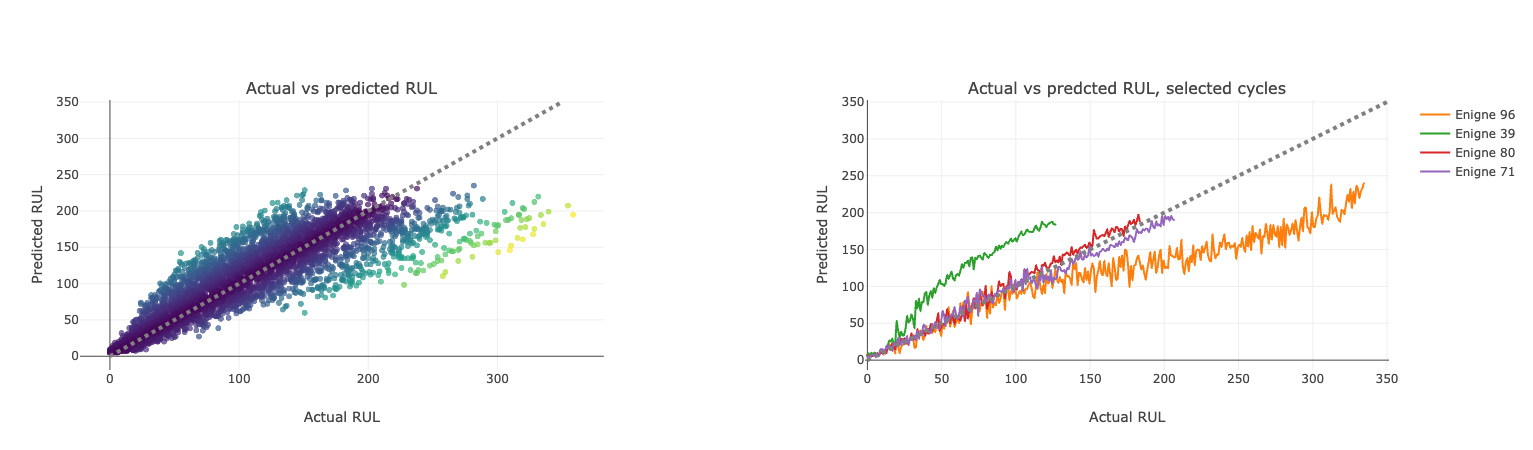

In [28]:
actual_vs_pred(model, X_test, y_test, df_train_proc2)

Next, we analyze the trained model and infer how each of the sensors contribute to the decrease of RUL. Conclusions are stated at the bottoom.

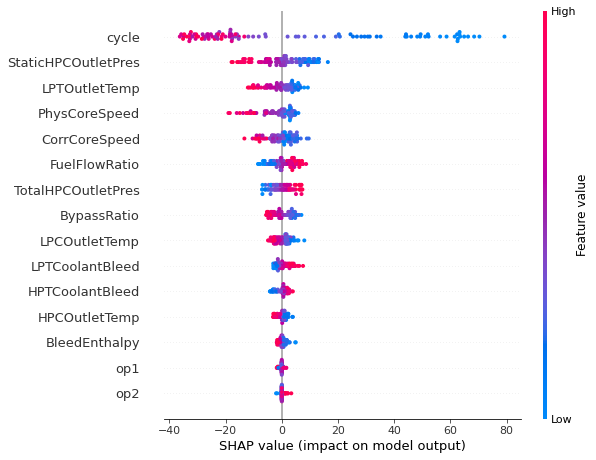

In [29]:
data_shap = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(model.predict, data=data_shap)

X_sample = X_train.sample(100)
with warnings.catch_warnings(record=True):
    shap_values = explainer.shap_values(X_sample, l1_reg="num_features(100)")

# summarize the effects of all the features
shap.summary_plot(shap_values, X_sample)

From the SHAP plot above we conclude that:

- Features are sorted in order of relevance from top to bottom
- Higher values of cycle (highligthed in red) are associated with lower RUL. This makes a lot of sense: the longer the engine has been running, the closest it is to failure
- The second most important feature is `StaticHPCOutletPres`: higer values of pressure indicate lower RUL.
- Analogous conclucions are drawn for the third and fourth most important variables (`PysCoreSpeed` and `CorrCoreSpeed`)

Similar conclusions are drawn from the Partial Dependence PLots (PDP) below. PDP plots show the expected change in RUL versus each variable taken independently. In other words, it shows the marginal effect of each of the variables or sensors. Note that on the y axis we show the _change_ of RUL.


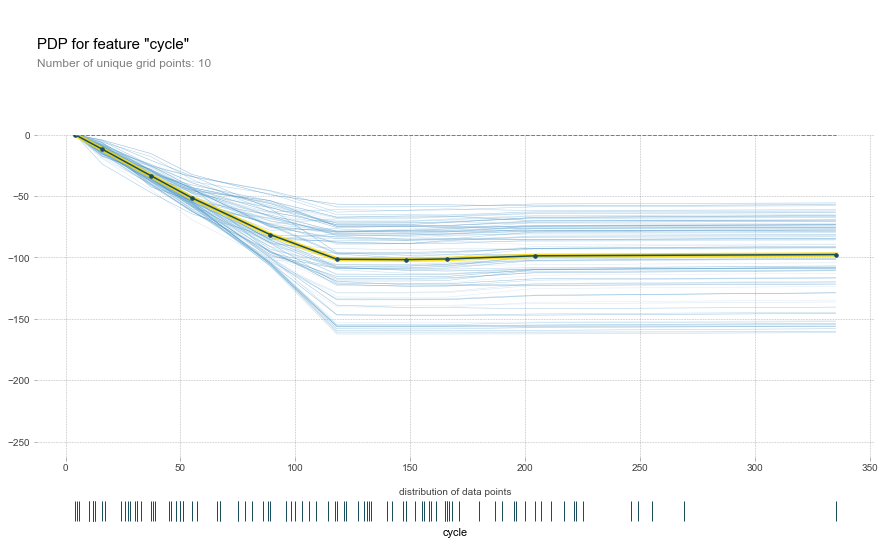

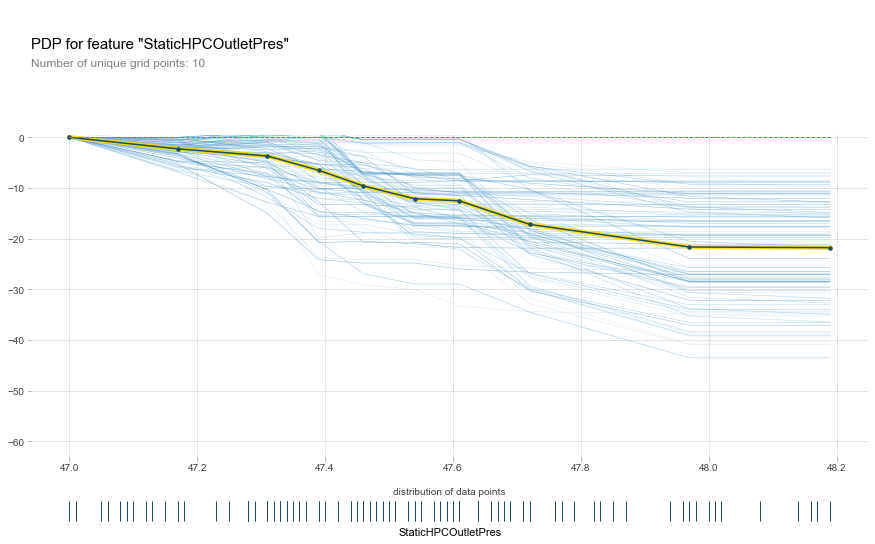

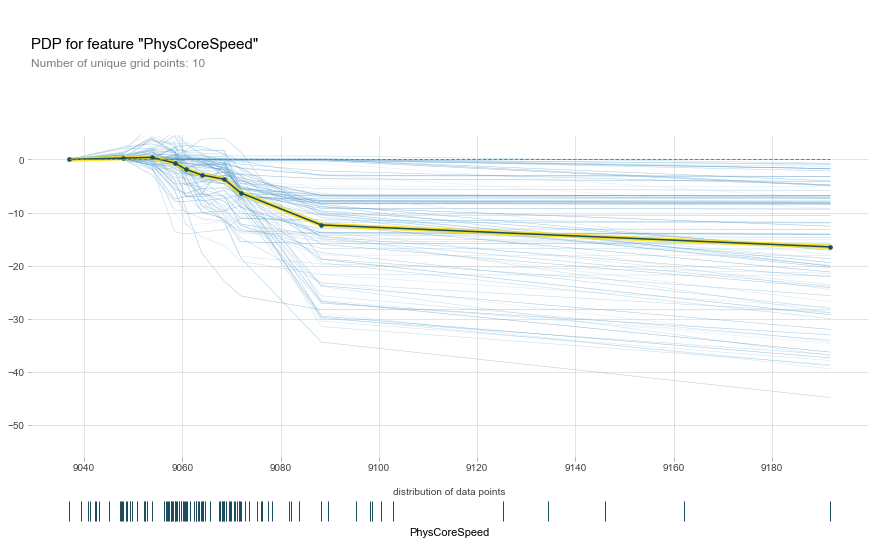

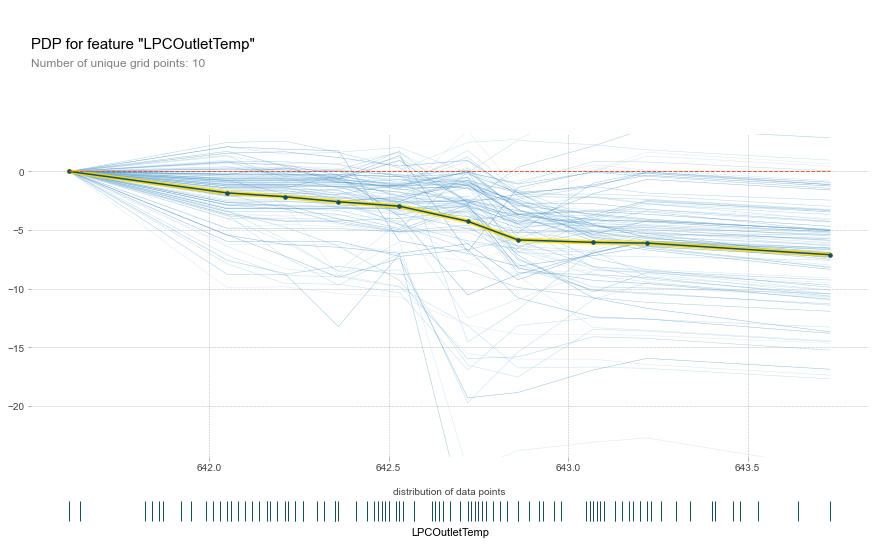

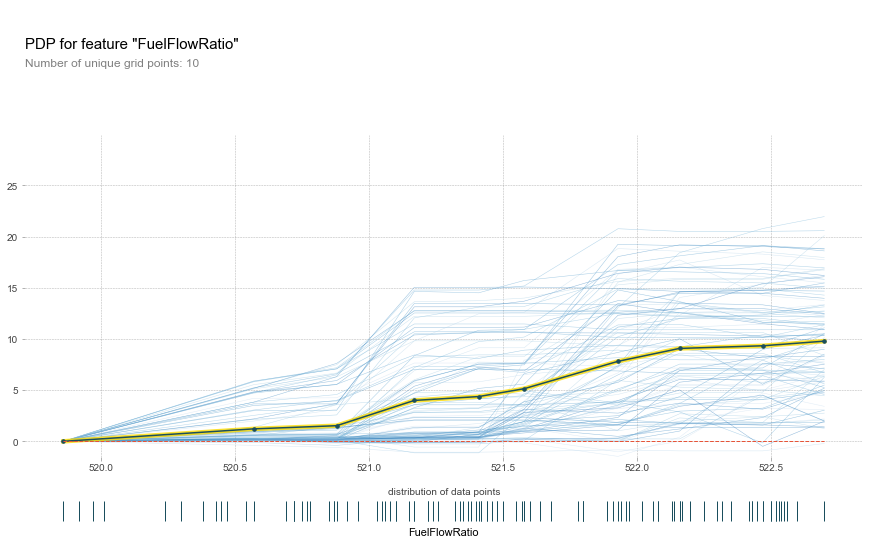

In [30]:
# Select which features to show
features = [
    "cycle",
    "StaticHPCOutletPres",
    "PhysCoreSpeed",
    "LPCOutletTemp",
    "FuelFlowRatio",
]

for f in features:

    pdp_goals = pdp.pdp_isolate(
        model=model, dataset=X_sample, model_features=X_train.columns, feature=f
    )
    pdp.pdp_plot(
        pdp_goals, f, x_quantile=False, plot_pts_dist=True, plot_lines=True, center=True
    )

## 3.3 Conclusion from Root-Cause Analysis of RUL

- The number of cycles has a big impact on the RUL. The effect of the cycle stabilizes once the engine reaches 120 cycles.
- The sensor corresponding to StaticHPCOutletPres is the most important: higer values of pressure indicate lower RUL. Can we limit this pressure in practice? This could be discussed with an expert in turbofan engines.
- The operational chacteristics, which a priori would be relevant, are not important when predicting the RUL.



# 4. Engine failure alerts

In this section, we deal with the case that the engineers need an alert system that will warn them if the engine will fail in less than 10 cycles, which will allow them to stop the engine and fix it before it breaks. In other words¡: they need to answer:

> _Will the engine fail in less than 10 cycles? With what probability?_


Here we utilise the cleaned dataset but look at the same problem from a different perspective. Instead of modeling _"number of cycles"_, we model the _probability_ that the engine fails within 10 cycles. This alternative approach could be very useful in practice to generate real-time alerts.



## 4.1 Classification model: Training and Selection

The approach we follow is very similar as above, except that now we use classification models: 

1. Logistic regression
2. Boosted classification trees
3. Neural networks (Multilayer perception) with log-loss function

We train the 3 types of models with different combination of hyperparameters, respecting the principles of cross-validation to avoid overfitting. The best modle is chosen according to the f1-score.


In [31]:
cycle_threshold = 10
df_train_proc2["RUL_thres"] = np.where(df_train_proc2["RUL"] <= cycle_threshold, 1, 0)

In [32]:
# Define models
models = {
    "lgb": lgb.LGBMClassifier(),
    "logistic": LogisticRegression(max_iter=300),
    "mlp": Pipeline(
        [("std", MinMaxScaler()), ("m1", MLPClassifier(early_stopping=True))]
    ),
}

# Define hyperparam search space
params = {
    "lgb": {
        "n_estimators": [100, 500],
        "learning_rate": [0.005, 0.01],
        "max_depth": [5, 10, 15, 20],
    },
    "mlp": {
        "m1__hidden_layer_sizes": [(128), (64, 32)],
        "m1__learning_rate_init": [0.001, 0.005, 0.01],
    },
    "logistic": {},
}

In [33]:
X_train, X_test, y_train, y_test = prepare_training_data(
    df=df_train_proc2, target_col="RUL_thres", discard_cols=["id", "RUL"]
)

In [34]:
%%time
estim_grid_clf = EstimatorSelectionHelper(models, params)
estim_grid_clf.fit(X_train, y_train, scoring="f1", n_jobs=2, cv=None)

Running GridSearchCV for lgb.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.3s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   30.1s finished


Running GridSearchCV for logistic.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.4s finished


Running GridSearchCV for mlp.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   32.4s finished


CPU times: user 14.9 s, sys: 1.47 s, total: 16.3 s
Wall time: 1min 7s


Below we show the top 5 best models. Again, in this case, tree-based model outperform neural networks and logstic regression models, both in accuracy and in training times.

In [35]:
estim_grid_clf.score_summary().head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,model,param_m1__hidden_layer_sizes,param_m1__learning_rate_init
13,1.098688,0.048010,0.031573,0.000682,0.01,15,500,"{'learning_rate': 0.01, 'max_depth': 15, 'n_es...",0.850440,0.840909,0.811429,0.796610,0.814159,0.822709,0.019908,1,0.992908,0.991489,0.994310,0.994302,0.994294,0.993461,0.001124,lgb,NaN,NaN
2,2.263911,1.219623,0.011597,0.000416,NaN,NaN,NaN,"{'m1__hidden_layer_sizes': 128, 'm1__learning_...",0.828402,0.852368,0.813056,0.824147,0.790960,0.821787,0.020055,1,0.811012,0.825352,0.824335,0.817766,0.824658,0.820624,0.005531,mlp,128,0.01
15,1.068679,0.143779,0.039355,0.009288,0.01,20,500,"{'learning_rate': 0.01, 'max_depth': 20, 'n_es...",0.847953,0.843305,0.810345,0.797753,0.809384,0.821748,0.020050,2,0.993612,0.990071,0.993612,0.995018,0.996436,0.993750,0.002116,lgb,NaN,NaN
9,0.775660,0.034736,0.040067,0.006253,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.840580,0.840580,0.819209,0.790960,0.816327,0.821531,0.018400,3,0.927247,0.923735,0.934097,0.930000,0.929638,0.928943,0.003411,lgb,NaN,NaN
11,1.052498,0.060512,0.038266,0.003218,0.01,10,500,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.849558,0.832370,0.819484,0.793201,0.807018,0.820326,0.019561,4,0.987216,0.987234,0.989339,0.986419,0.988588,0.987759,0.001054,lgb,NaN,NaN


In [36]:
model = estim_grid_clf.best_model
y_test_pred = model.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print(f"F1 score test: {f1:.3f}")

F1 score test: 0.836


## 4.2 Model Diagnostics and Interpretation

Below we graph the predicted probability of failure given by the model versus the actual remaining useful life, for one of the engines. The model outputs reasonable probabilities on most occasions. Its confidence grows as the failure time approaches.

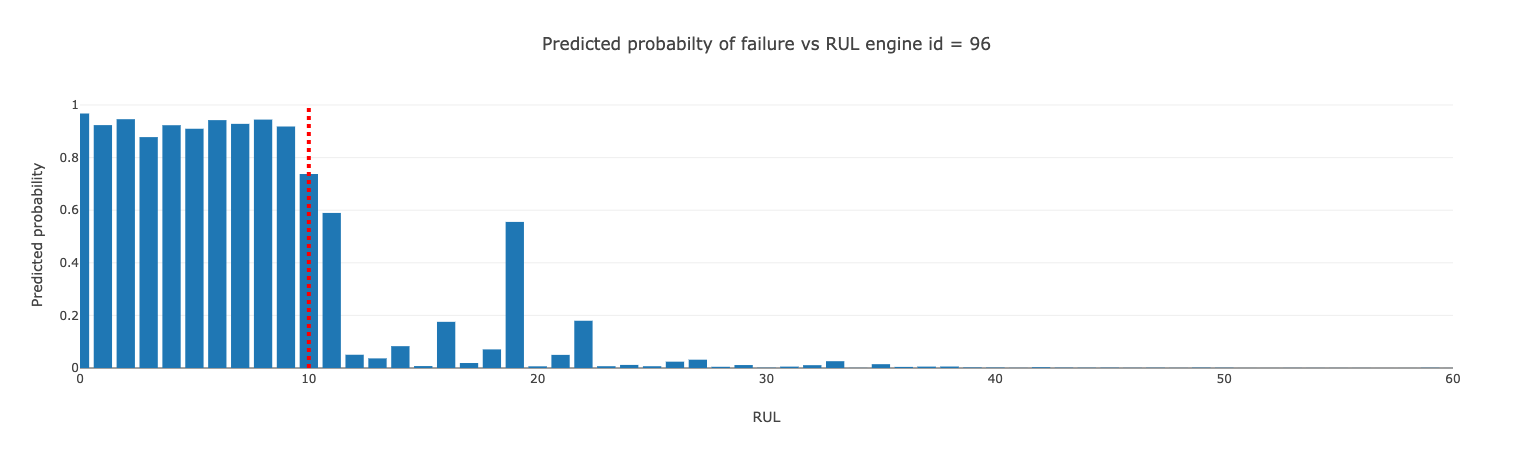

In [37]:
plot_prob_RUL(model, df_train_proc2, engine=96)

Classification models return a probabbility of failure. If we define a **threshold**, we can translate this probability to a binary variable: 1 indicates failure, 0 indicates no failure. Below, we select a few thresholds and compare how many failures are predicted correctly (true positives) versus how many false positives we observe. A false positives means we predict "failure" but in fact, it was not.

There is a certain trade-off between true and false positives. Depending on the cost of a false positive and the benefit from true positives we can establish a theshold to be used in practice.

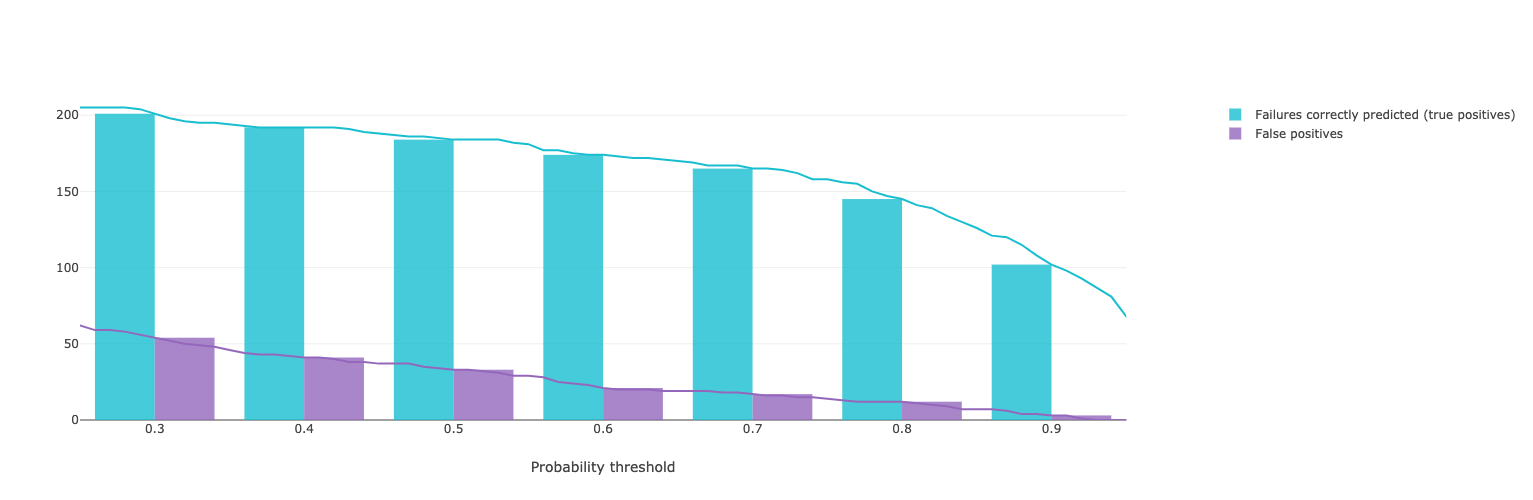

In [38]:
# Predict for test set
y_score = model.predict_proba(X_test)
metrics = metrics_threshold(y_score[:, 1], y_test)

# Display true positives vs false positives
display_tp_fp(
    thres=metrics["thres"],
    tp=metrics["tp"],
    fp=metrics["fp"],
    title="",
    fig=None,
    i=0,
    name1="Failures correctly predicted (true positives)",
    name2="False positives",
)

It is interesting to look at the ratios too and not just as the absolute values. We define the following metrics which are universal for all classification problems. The reader is referred to [this article](https://en.wikipedia.org/wiki/Precision_and_recall) for further information:

- Precision: fraction of predictions were correct
- False positive rate: fraction of times we predict a failure and then it is not
- Recall: fraction of failures were predicted correctly. In other words, amongst all failures, how many do we predict correctly?
- Threshold: translates probability of failure to a binary variable.

Looking at the ROC-Precision graph below is another way of choose an optimal **threshold** based on the business needs. The table shows the same data as the graph.

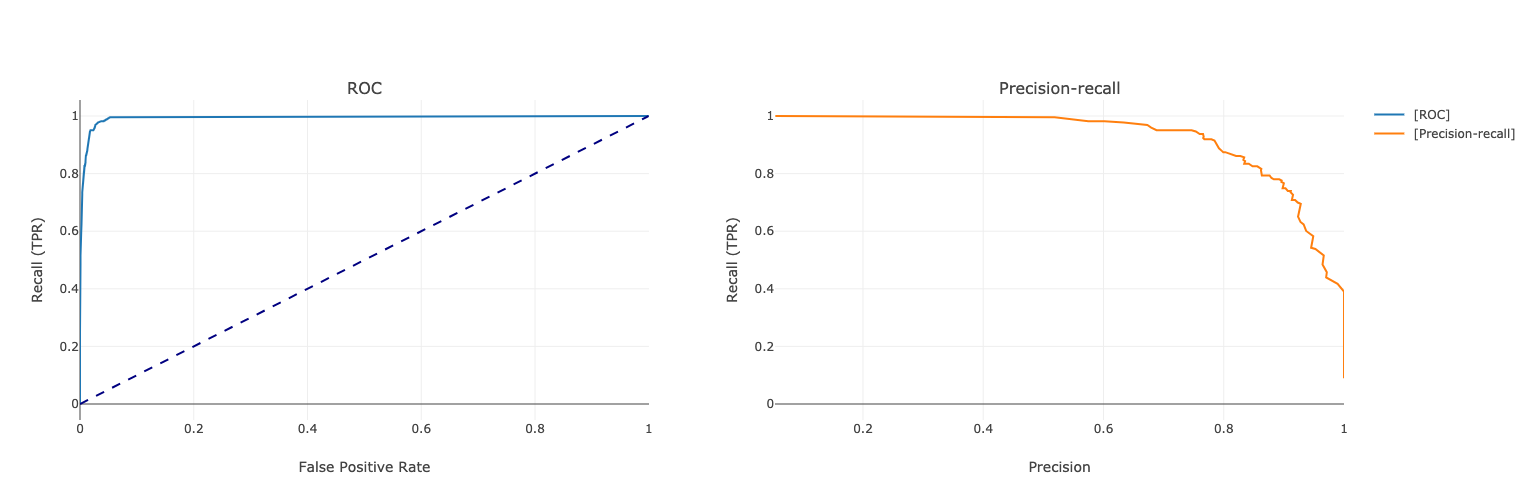

,thresholds,precision,recall,fpr,TP,TN,FP,FN
100,1.0,NaN,0.000,0.000,0,3904,0,223
90,0.9,0.971,0.457,0.001,102,3901,3,121
80,0.8,0.924,0.650,0.003,145,3892,12,78
70,0.7,0.907,0.740,0.004,165,3887,17,58
60,0.6,0.892,0.780,0.005,174,3883,21,49
50,0.5,0.848,0.825,0.008,184,3871,33,39
40,0.4,0.824,0.861,0.011,192,3863,41,31
30,0.3,0.788,0.901,0.014,201,3850,54,22
20,0.2,0.754,0.946,0.018,211,3835,69,12
10,0.1,0.679,0.960,0.026,214,3803,101,9


In [39]:
display_roc_pr(
    precision=metrics["prec"],
    recall=metrics["rec"],
    fpr=metrics["fpr"],
    thres=metrics["thres"],
).show()

# Display table too
display(
    pd.DataFrame(
        {
            "thresholds": metrics["thres"],
            "precision": metrics["prec"],
            "recall": metrics["rec"],
            "fpr": np.round(metrics["fpr"], 3),
            "TP": metrics["tp"],
            "TN": metrics["tn"],
            "FP": metrics["fp"],
            "FN": metrics["fn"],
        }
    )
    .loc[::10]
    .loc[::-1]
    .round(3)
)

If we select a theshold of 0.5, we can expect 0.8% of false positives, and more than 80% in precision and recall. This seems reasonable from a business-perspective. Below we show the confusion matrix for such selected threshold.

Confusion matrix, without normalization


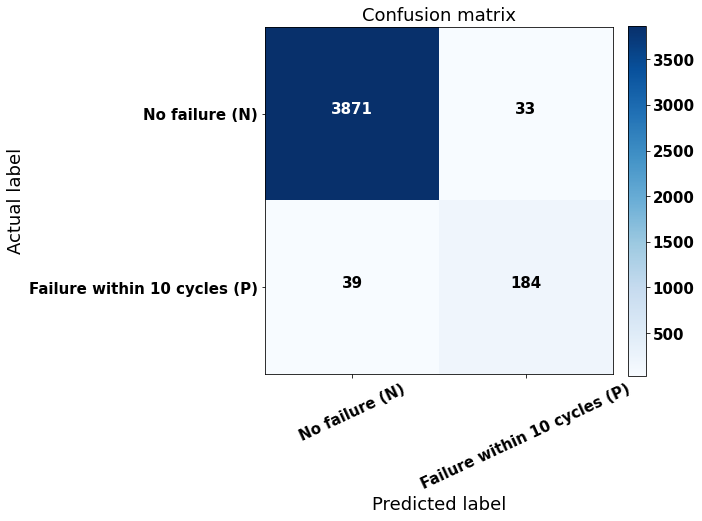

In [49]:
thres = 0.5
y_test_pred = np.where(model.predict_proba(X_test)[:, 1] >= thres,1,0)

confusionMatrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(
    confusionMatrix,
    normalize=False,
    classes=["No failure (N)", "Failure within 10 cycles (P)"],
)

# 5. Summary and Conclusions

In this notebook we deal with data relative to turbofan engines. We have pre-processed a dataset and visualized it to spot outliers and unexpected behaviors. Once it was clean and ready to be ingested by machine learning models, we trained two different types of models:

- A regression model: _How many cycles are left until the engine fails?_
- A classification model: _Will the engine fail in less than 10 cycles? What is the probability?_

During the modeling phase, we tested 3 different types of models with numerous hyperparameter combinations, always respecting the principles of cross validation and selecting the best one based on relevant metrics.

From the regression model, we concluded that the number of cycles since the engine started is the most relevant factor when predicting the remaining useful life. The next most importance variable is `StaticHPCOutletPres`, so further analysis together with turbofan experts should be conducted to understand the physical implication of this variable. We also concluded that the operational characteristics of the engines are not relevant features. 

When predicting _if_ the engine wil fail in less than 10 cycles, the model achieves precisions of 80-90% with a false positive rate of 0.1-0-8%.


# 6. Further Work

From the data and modeling point of view, this problem could be improved in two ways:

- Gather more data.
- Create new columns, also known as _Feature Engineering_. For example, we could add a moving-average window to each sensor that filters out noise.
- Further model architectures could be explored, especially the ones that take advantage of inter-temporal relationships.

On a practical level, it would be interesting to answer further business questions. For example: 

- Will the engine fail in less than 10 cycles, in between 10 and 20, or in more than 20? This could be implemented in practice as a red-yellow-green trafficlight.
- Can we detemine the _most likely_ cause of the next failure? We would need to explore shap values for the classification problem as well.

# 